In [1]:
!nvidia-smi

Sat Dec 28 16:48:32 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install gdown
!pip install tensorflow-gpu

     |████████████████████████████████| 380.8MB 44kB/s 
     |████████████████████████████████| 450kB 36.5MB/s 
     |████████████████████████████████| 3.8MB 61.1MB/s 
     |████████████████████████████████| 81kB 13.6MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled goo

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [0]:
df = pd.read_csv('/content/drive/My Drive/Time Series Anomaly Detection with LSTM and Autoencoders/nepse.csv', parse_dates=['date'], index_col='date')

In [6]:
df.head()

,value
date,
1995-01-23,200.61
1995-01-24,201.50
1995-01-25,213.87
1995-01-26,212.54
1995-01-29,207.80


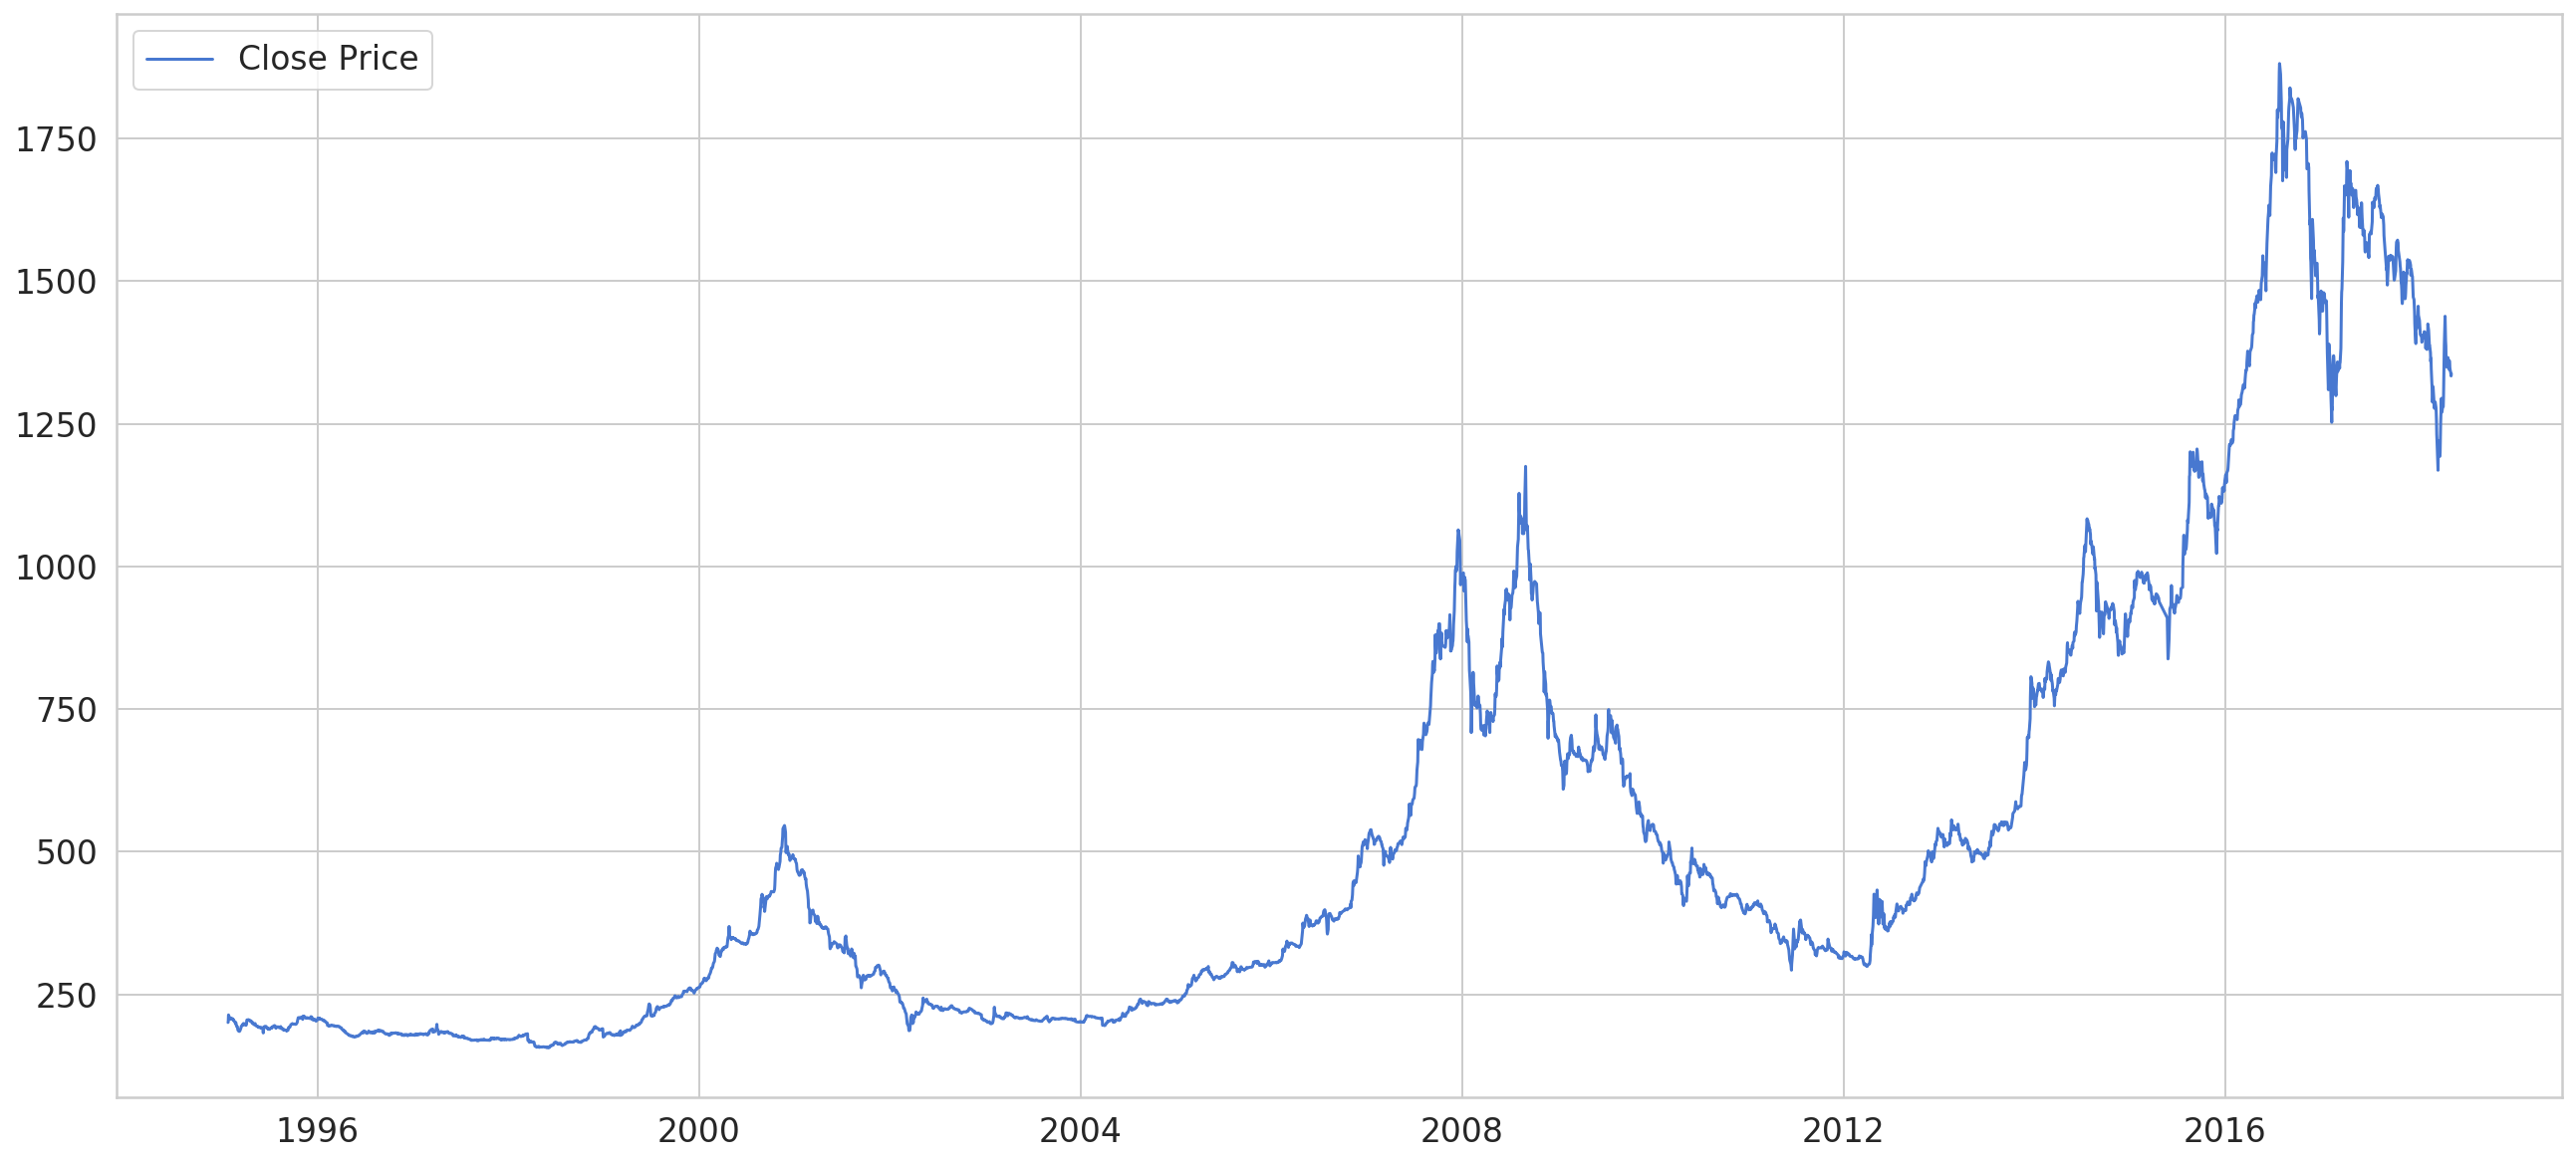

In [7]:
plt.plot(df, label='Close Price')
plt.legend();

In [8]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(5126, 1) (270, 1)


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['value']])

train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [0]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [13]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['value']], train.value, TIME_STEPS)
X_test, y_test = create_dataset(test[['value']], test.value, TIME_STEPS)

print(X_train.shape)

(5096, 30, 1)


In [0]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=128, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.1))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.1))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [20]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=10,
    validation_split=0.1,
    shuffle=False
)

Train on 4586 samples, validate on 510 samples
Epoch 1/30
4586/4586 [==============================] - 7s 2ms/sample - loss: 0.0861 - val_loss: 0.8104
Epoch 2/30
4586/4586 [==============================] - 4s 785us/sample - loss: 0.0779 - val_loss: 0.6523
Epoch 3/30
4586/4586 [==============================] - 4s 828us/sample - loss: 0.0670 - val_loss: 0.5249
Epoch 4/30
4586/4586 [==============================] - 4s 795us/sample - loss: 0.0575 - val_loss: 0.6464
Epoch 5/30
4586/4586 [==============================] - 4s 763us/sample - loss: 0.0561 - val_loss: 0.5957
Epoch 6/30
4586/4586 [==============================] - 3s 759us/sample - loss: 0.0540 - val_loss: 0.4127
Epoch 7/30
4586/4586 [==============================] - 4s 816us/sample - loss: 0.0502 - val_loss: 0.4980
Epoch 8/30
4586/4586 [==============================] - 4s 786us/sample - loss: 0.0486 - val_loss: 0.4144
Epoch 9/30
4586/4586 [==============================] - 4s 786us/sample - loss: 0.0479 - val_loss: 0.4625
E

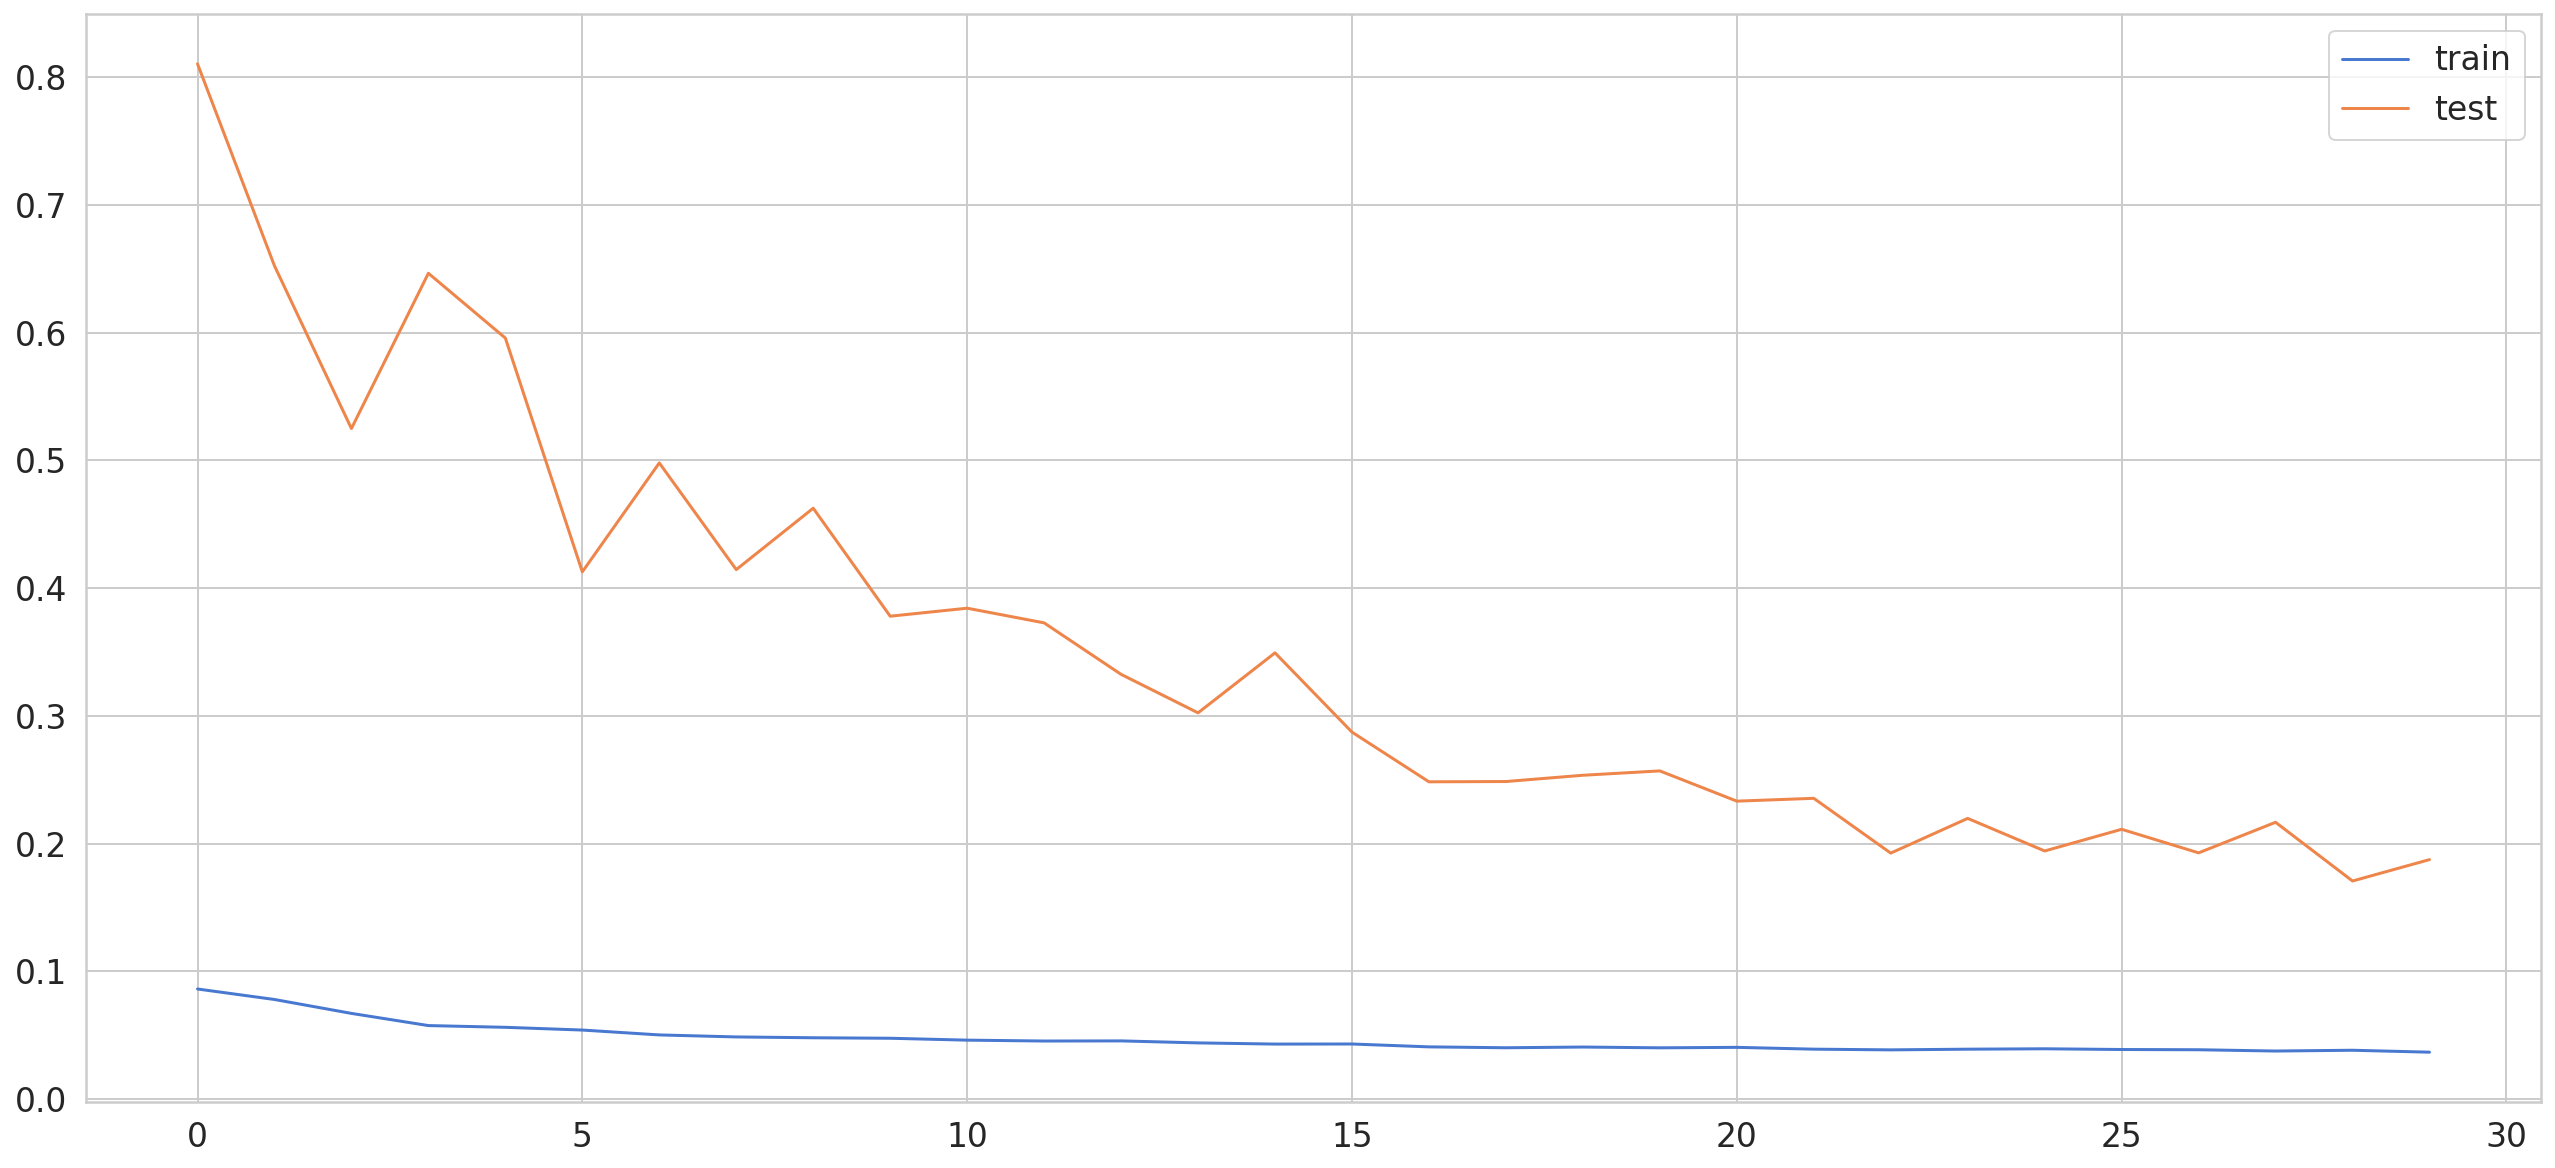

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [0]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

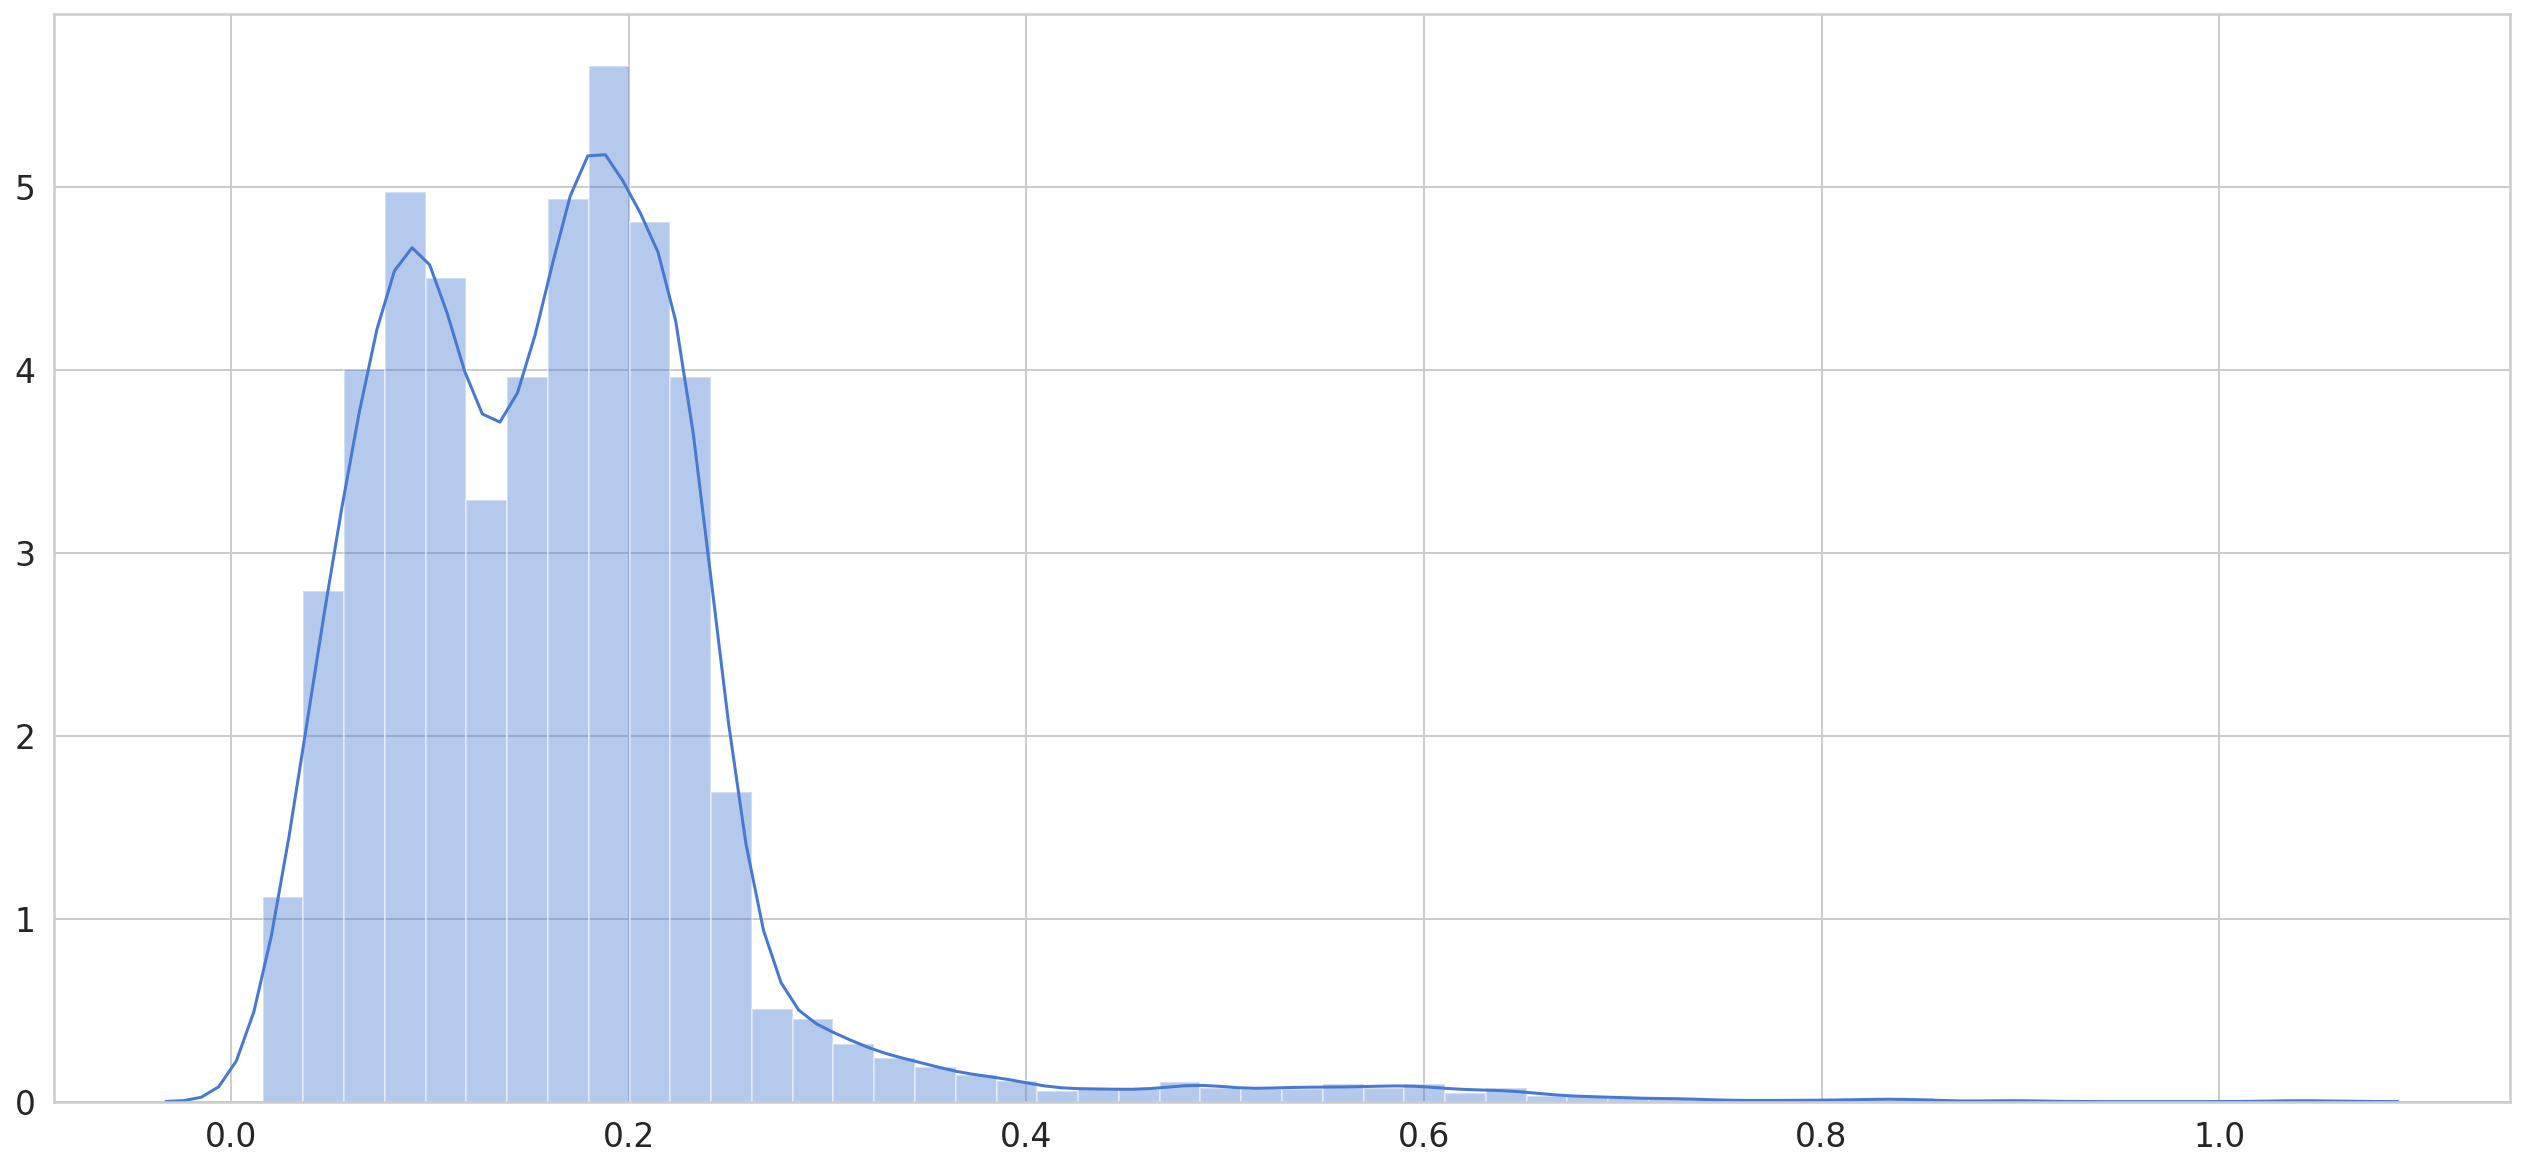

In [23]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [0]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [0]:
THRESHOLD = 0.50

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['value'] = test[TIME_STEPS:].value

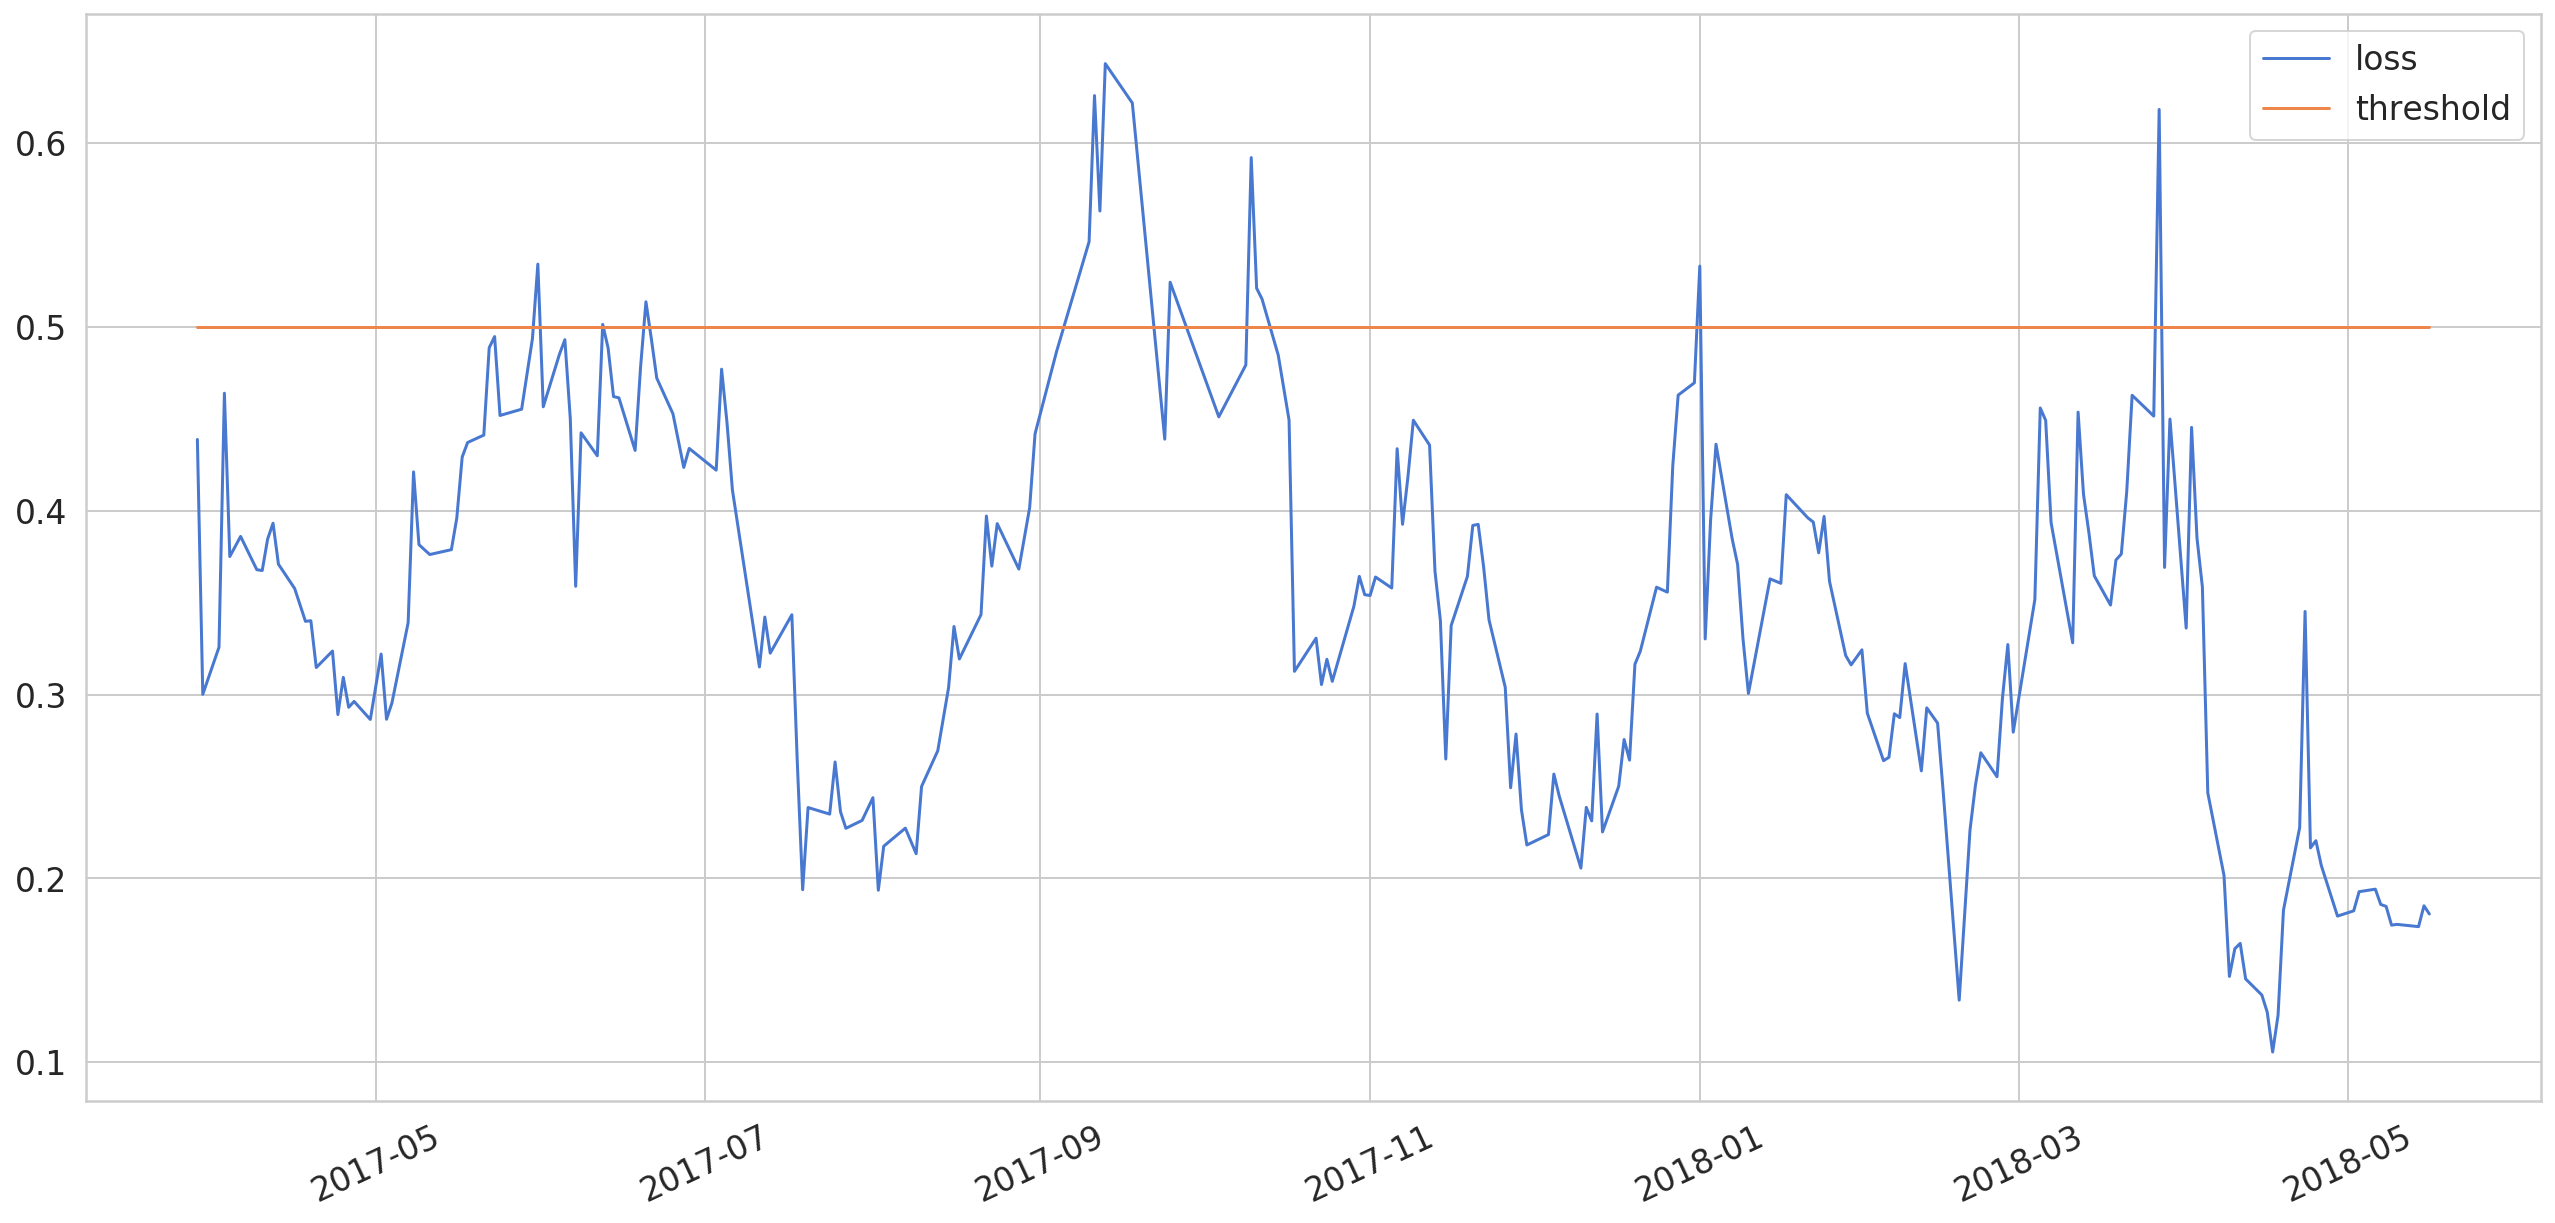

In [33]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [34]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,value
date,,,,
2017-05-31,0.534201,0.5,True,3.205963
2017-06-12,0.501411,0.5,True,3.128035
2017-06-20,0.513698,0.5,True,3.044853
2017-09-10,0.546405,0.5,True,2.956134
2017-09-11,0.625896,0.5,True,2.966303
